# Datenanalyse des Wohnraumes

Aus unserer Fragestellung heraus nimmt uns wunder, ob wir mit dem Model auch die benötigte Wohnfläche einer Gemeinde voraussagen können. Für dies brauchen wir aber Informationen über den leerstehenden Wohnraum. Auf der Webseite von LUSTAT https://www.lustat.ch/daten?fachbereich=157&raumtyp=101 finden wir Informationen bezüglich Wohnungen und Leerwohnung pro Jahr, sowie Anzahl der Zimmer dieser Wohnungen. Zudem gibt es dort auch Informationen über die Wohnungsfläche https://www.lustat.ch/daten?fachbereich=157&stichwort=Wohnungsfl%C3%A4che von Wohnungen aufgeteilt anhand deren Anzahl an Zimmer.

In diesem Notebook wird nun aufgezeigt, wie wir diese Zahlen errechnet haben.


> **ACHTUNG!** Zellen in diesem Notebook brauchen nicht länger als fünf Sekunden zur Ausführung. Es können also alle ausgeführt werden, ohne die Outputs zu verlieren. 

In [26]:
# install Libraries
# run this if you do not have all the libraries installed
# -U flag was omitted because it is not probably necessary to upgrade the libraries
!pip install pandas
!pip install geopandas
!pip install scikit-learn
!pip install matplotlib
!pip install numpy

In [27]:
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# get prepared data from csv
# base_data_empty_apartments
#   - contains the number of empty apartments per year
# base_data_area_apartments
#   - contains the area of apartments per amount of rooms
base_data_empty_apartments = pd.read_csv('./Data/Preparation/merged_leerwohnungen.csv')
base_data_area_apartments = pd.read_csv('./Data/Preparation/wohnungsflaechen.csv')

Die beiden eingelesenen Datensätze sind teils in unterschiedlichen Jahren aufgenommen worden. Für uns sind nur die Daten relevant, von denen wir in beiden Jahren auch Daten haben. Andere Datensätze werden aus den DataSets entfernt.

In [29]:
print("Available years for area data: ")
print(base_data_area_apartments.ExcelDate.unique())
print()
print()
print("Available years for empty apartments data:")
print(base_data_empty_apartments.Jahr.unique())
print()
print()
print("Years available in both datasets:")
years_in_both_datasets = np.intersect1d(base_data_empty_apartments.Jahr.unique(), base_data_area_apartments.ExcelDate.unique())
print(years_in_both_datasets)

Available years for area data: 
[1990 2000 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021]


Available years for empty apartments data:
[1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


Years available in both datasets:
[1990 2000 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021]


In [30]:
# Drop all years that are not available in both datasets
base_data_area_apartments = base_data_area_apartments[base_data_area_apartments["ExcelDate"].isin(years_in_both_datasets)].reset_index(drop=True)
base_data_empty_apartments = base_data_empty_apartments[base_data_empty_apartments["Jahr"].isin(years_in_both_datasets)].reset_index(drop=True)

Um eine Übersicht über die Wohnungsgrössen und deren Verteilung zu erhalten, analysieren wir das Dataframe `base_data_area_apartments` im Jahr 2020. Dies gibt Aufschluss über die Aufteilung der Wohnungsgrössen, da wir diese nicht aufgeteilt pro Gemeinde zur Verfügung stehen.

In [31]:
base_data_area_apartments[base_data_area_apartments['ExcelDate'] == 2020].head(15)

,Bauperiode,Wohnungen_Total,Davon_Einfamilienhaeuser,1or2_Zimmer,3or4_Zimmer,5_Zimmer_und_mehr,0to49m,50to99m,100to149m,150m_und_mehr,ohne_Angaben,ExcelDate
110,Vor 1919,20466,1971,3507,10664,6295,2165,9287,5814,3200,0,2020
111,1919-1945,16915,2163,2370,10063,4482,1319,9156,4187,2253,0,2020
112,1946-1960,20362,2398,3404,13248,3710,2065,13145,3643,1509,0,2020
113,1961-1970,23925,2552,4488,15013,4424,3036,14274,4893,1722,0,2020
114,1971-1980,25113,4515,4852,13193,7068,2693,11597,7431,3392,0,2020
115,1981-1990,24043,5323,4405,11919,7719,1638,9145,8737,4523,0,2020
116,1991-2000,24698,5229,3480,13059,8159,1062,8243,10225,5168,0,2020
117,2001-2010,20675,5139,1757,10088,8830,491,4527,9733,5924,0,2020
118,Ab 2011,28270,3050,5169,16599,6502,1065,10786,11896,4523,0,2020


Es gibt hauptsächlich Wohnungen und Häuser mit einer Wohnfläche von 50 bis 150 Quadratmeter. Dies kann auch summiert in einem Plot dargestellt werden.

<BarContainer object of 4 artists>

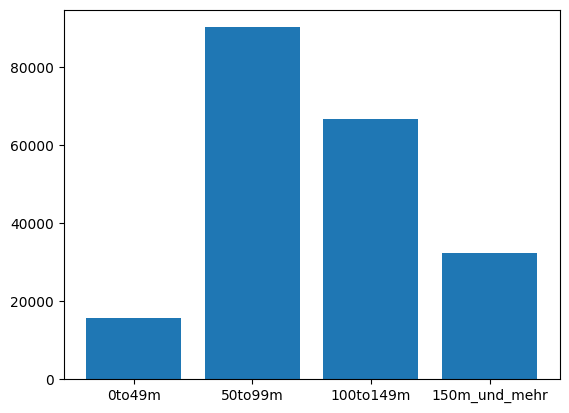

In [32]:
summed = base_data_area_apartments[base_data_area_apartments['ExcelDate'] == 2020].agg({'0to49m': 'sum','50to99m': 'sum','100to149m': 'sum','150m_und_mehr': 'sum' })

plt.bar(summed.index, summed.values)

Da es kein 1:1 Mapping von Anzahl Zimmer auf Fläche einer Wohnung gibt, müssen wir anhand Wahrscheinlichkeit die Fläche aufteilen. Dies sollte jedoch vom Bauamt oder der Gemeinde selbst genau angegeben werden können. Dies würde es dann ermöglichen den effektiv verfügbaren Platz noch genauer darzustellen.

Für unsere Annahme gehen wir davon aus das:

1-Zimmer zu     65% <50m^2 ist\
                27% zwischen 50 und 100m^2 ist\
                5%  zwischen 100 und 150 m^2 ist\
                3%  mehr als 150 m^2 hat

Dies wird im Code in einen Array gepackt und wiederum mit einer zweiten Dimension versehen, um die einzelnen Wohnungen mit unterschiedlicher Anzahl an Zimmern abzubilden.\
[[65, 27, 5, 3]]

In [33]:
apartment_size_probability = [
    np.array([65, 27, 5, 3]), # 1-Zimmer
    np.array([30, 49, 15, 6]), # 2-Zimmer
    np.array([27, 48, 19, 6]), # 3-Zimmer
    np.array([12, 52, 29, 7]), # 4-Zimmer
    np.array([2, 37, 48, 13]), # 5-Zimmer
    np.array([0, 5, 69, 26]), # 6 und mehr Zimmer
]

In [34]:
# Create new column containing the amount of square meters per apartment
base_data_empty_apartments['sum_space_sqm'] = 0

In [35]:
# Based on the probability of the room distribution of a apartment in a given size, we generate size in square meters for each apartment.
seed = 170
rng = np.random.default_rng(seed=seed)

for k, val in base_data_empty_apartments.iterrows():
    sum_space_in_row = 0
    for i, y in enumerate( ['1_Zimmer','2_Zimmer','3_Zimmer','4_Zimmer','5_Zimmer','6_Zimmer_und_mehr'] ):
        # Contains a value between 1 and 4 which will be multiplied by 50 to get the apartments size in square meters.
        # The probability of the temp-value is based on the room distribution of a apartment in a given size.
        temp = np.sum(rng.choice(np.arange(1, 5), val[y], p=apartment_size_probability[i] / 100))
        sum_space_in_row += temp * 50
    base_data_empty_apartments.loc[k, 'sum_space_sqm'] = sum_space_in_row

Ansicht von fünf Datensätzen vom Jahr 2020

In [36]:
base_data_empty_apartments[base_data_empty_apartments.Jahr == 2020][['Gemeinde', 'Leerwohnungen_in_Prozent', 'Jahr', 'sum_space_sqm']].head(5)

,Gemeinde,Leerwohnungen_in_Prozent,Jahr,sum_space_sqm
1040,Adligenswil,0.29,2020,650
1041,Aesch,0.76,2020,600
1042,Alberswil,7.03,2020,2650
1043,Altbüron,2.90,2020,1450
1044,Altishofen,2.73,2020,2650


Mit diesen Daten können wir nun unser Model laden und auswerten, ob eine Gemeinde mehr Wohnraum schaffen muss. Da unser Model auf Daten von acht Jahren zurück trainiert wurde (bis Jahr 2014), können wir den Output auch gleich validieren.

Eine erwachsene Person benötigt in etwa 46 Quadratmeter laut LUSTAT https://www.lustat.ch/analysen/bauwesen-wohnungswesen/bauen-und-wohnen/bedarf. Wir können nun also für das Jahr **2020** eine Voraussagung machen für zum Beispiel die Gemeinde **Alberswil** und dies mit den berechneten Werten im DataSet `base_data_empty_apartments` vergleichen.

In [37]:
# Load the model from file
import pickle
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
model = pickle.load(open('./weights/model_weights.pkl', "rb"))

Um richtig skalierte Daten zu erhalten, müssen die Daten vom Training erneut eingelesen und skaliert werden. Jedoch braucht es nun den Target Wert nicht mehr. `read_excel` und `train_test` sind also vom Training Prozess übernommene Funktionen, die die Daten einlesen und richtig segmentieren.

Um nicht für jede Voraussagung das Excel einlesen zu müssen wird weiter unten das eingelesene Excel als DataFrame in die Variable `DATA_NO_OVERWRITE` geschrieben. Zudem wird auch gleich die Segmentation durchgeführt. So kann der StandardScaler die Daten optimal für das Modell skalieren.

In [38]:
def read_excel():
    column_names_to_load = [
        'Siedlungsfläche_in_%', 
        'Landwirtschafts-fläche_in_%',
        'Betriebe_total',
        'Wohnungen - Total',
        'Anzahl_Privathaushalte',
        'Gemeindename', 
        'Gemeindetypologien']

    # Load all data from excel
    path = 'Data/Preparation/Kennzahlen_aller_Gemeinden/Alle_Daten.xlsx'
    data = pd.read_excel(path, header=[0,1], index_col=[0,1])

    # Extract wanted columns
    column_mask = data.columns.isin(column_names_to_load, level=1)
    data = data.loc[:, column_mask]

    # Drop top level column names
    data = data.droplevel(0,axis=1)

    # Reset index
    data = data.reset_index()
    
    return data

def train_test_split(data, test_length):
    start_year = 1991
    amount_of_years = 30

    # Define length of splits
    train_length = amount_of_years - test_length

    # Define years where train and validation split ends
    train_data_end_year = start_year + train_length

    # Apply splits
    train = data[data['Jahr'] <= train_data_end_year]
    test = data[data['Jahr'] > train_data_end_year]
    
    return train, test

In [39]:
DATA_NO_OVERWRITE = read_excel()
DATA_NO_OVERWRITE.drop(columns=['Gemeindecode'], inplace=True)
TRAIN_LENGTH = 22
TEST_LENGTH = 8
DATA_NO_OVERWRITE, ValidationData = train_test_split(DATA_NO_OVERWRITE, TEST_LENGTH)

Um nun einfacher eine Voraussagung machen zu können wurde eine Wrapper Funktion mit folgender Definition geschrieben:
```python
def do_predict(model: SVR,
               for_year: int,
               for_municipality: str,
               estimated_settlement_area_in_percent: float,
               estimated_agriculture_area_in_percent: float,
               estimated_businesses_total: int,
               estimated_apartments_total: int,
               estimated_private_household_total: int
            ) -> float:
```
Diese gibt die *Ständige Wohnbevölkerung Total* für die Gemeinde (Parameter `for_municipality`), dem Jahr (Parameter `for_year`) und den Schätzungen für Wohnraum, Landwirtschaftsfläche, Anzahl Betriebe, Anzahl Wohnungen und Anzahl Privathaushalte zurück.

In [40]:
def do_predict(model: SVR,
               for_year: int,
               for_municipality: str,
               estimated_settlement_area_in_percent: float,
               estimated_agriculture_area_in_percent: float,
               estimated_businesses_total: int,
               estimated_apartments_total: int,
               estimated_private_household_total: int
            ) -> float:
    """
    Forecasts the total number of permanent resident population for a given year, municipality and set of characteristics.
    """

    MUNACIPALITIES_TOPOLIGIES = DATA_NO_OVERWRITE[['Gemeindename', 'Gemeindetypologien']].drop_duplicates().reset_index()

    try:
        _, mun, top = MUNACIPALITIES_TOPOLIGIES[MUNACIPALITIES_TOPOLIGIES['Gemeindename'] == for_municipality].values[0]
    except(IndexError):
        raise ValueError(f'The given municipality "{for_municipality}" is not part of the canton Luzern. Please check the spelling.')

    # create a dataframe with the given features
    df = pd.DataFrame([[mun, top]], columns=['Gemeindename', 'Gemeindetypologien'])
    df["Jahr"] = for_year
    df["Siedlungsfläche_in_%"] = estimated_settlement_area_in_percent
    df["Landwirtschafts-fläche_in_%"] = estimated_agriculture_area_in_percent
    df["Betriebe_total"] = estimated_businesses_total
    df["Wohnungen - Total"] = estimated_apartments_total
    df["Anzahl_Privathaushalte"] = estimated_private_household_total

    new_df = pd.concat([DATA_NO_OVERWRITE, df], ignore_index=True)
    
    # get dummie variables for the column Gemeindetypologien and Gemeindename in the X split
    df_with_dummies = pd.get_dummies(new_df, columns=['Gemeindetypologien', 'Gemeindename'])
    
    # reorganize the columns, columns must be in the same order as when the model was trained
    df_with_dummies = df_with_dummies[['Jahr', 'Siedlungsfläche_in_%', 'Landwirtschafts-fläche_in_%',
       'Betriebe_total', 'Wohnungen - Total', 'Anzahl_Privathaushalte',
       'Gemeindetypologien_Aggloguertel', 'Gemeindetypologien_Agglokern',
       'Gemeindetypologien_Kern', 'Gemeindetypologien_Land',
       'Gemeindename_Adligenswil', 'Gemeindename_Aesch',
       'Gemeindename_Alberswil', 'Gemeindename_Altbüron',
       'Gemeindename_Altishofen', 'Gemeindename_Ballwil',
       'Gemeindename_Beromünster', 'Gemeindename_Buchrain',
       'Gemeindename_Buttisholz', 'Gemeindename_Büron',
       'Gemeindename_Dagmersellen', 'Gemeindename_Dierikon',
       'Gemeindename_Doppleschwand', 'Gemeindename_Ebikon',
       'Gemeindename_Egolzwil', 'Gemeindename_Eich', 'Gemeindename_Emmen',
       'Gemeindename_Entlebuch', 'Gemeindename_Ermensee',
       'Gemeindename_Eschenbach', 'Gemeindename_Escholzmatt-Marbach',
       'Gemeindename_Ettiswil', 'Gemeindename_Fischbach',
       'Gemeindename_Flühli', 'Gemeindename_Geuensee', 'Gemeindename_Gisikon',
       'Gemeindename_Greppen', 'Gemeindename_Grossdietwil',
       'Gemeindename_Grosswangen', 'Gemeindename_Hasle',
       'Gemeindename_Hergiswil', 'Gemeindename_Hildisrieden',
       'Gemeindename_Hitzkirch', 'Gemeindename_Hochdorf',
       'Gemeindename_Hohenrain', 'Gemeindename_Honau', 'Gemeindename_Horw',
       'Gemeindename_Inwil', 'Gemeindename_Knutwil', 'Gemeindename_Kriens',
       'Gemeindename_Luthern', 'Gemeindename_Luzern', 'Gemeindename_Malters',
       'Gemeindename_Mauensee', 'Gemeindename_Meggen',
       'Gemeindename_Meierskappel', 'Gemeindename_Menznau',
       'Gemeindename_Nebikon', 'Gemeindename_Neuenkirch',
       'Gemeindename_Nottwil', 'Gemeindename_Oberkirch',
       'Gemeindename_Pfaffnau', 'Gemeindename_Rain', 'Gemeindename_Reiden',
       'Gemeindename_Rickenbach', 'Gemeindename_Roggliswil',
       'Gemeindename_Romoos', 'Gemeindename_Root', 'Gemeindename_Rothenburg',
       'Gemeindename_Ruswil', 'Gemeindename_Römerswil',
       'Gemeindename_Schenkon', 'Gemeindename_Schlierbach',
       'Gemeindename_Schongau', 'Gemeindename_Schwarzenberg',
       'Gemeindename_Schötz', 'Gemeindename_Schüpfheim',
       'Gemeindename_Sempach', 'Gemeindename_Sursee', 'Gemeindename_Triengen',
       'Gemeindename_Udligenswil', 'Gemeindename_Ufhusen',
       'Gemeindename_Vitznau', 'Gemeindename_Wauwil', 'Gemeindename_Weggis',
       'Gemeindename_Werthenstein', 'Gemeindename_Wikon',
       'Gemeindename_Willisau', 'Gemeindename_Wolhusen', 'Gemeindename_Zell']]

    # Scale the data with the StandardScaler
    scaler = StandardScaler()
    df_with_dummies = pd.DataFrame(scaler.fit_transform(df_with_dummies), columns=df_with_dummies.columns)

    return round(model.predict(df_with_dummies[-1:])[0], 0)


Und so kann diese Funktion aufgerufen werden:

In [41]:
estimate_for_Alberswil_2019 = do_predict(model,
           for_year=2019,
           for_municipality='Alberswil',
           estimated_settlement_area_in_percent=8.426966,
           estimated_agriculture_area_in_percent=72.191011,
           estimated_businesses_total=52,
           estimated_apartments_total=0,
           estimated_private_household_total=265)

print(estimate_for_Alberswil_2019)

796.0


In [42]:
estimate_for_Alberswil_2020 = do_predict(model,
           for_year=2020,
           for_municipality='Alberswil',
           estimated_settlement_area_in_percent=8.426966,
           estimated_agriculture_area_in_percent=72.191011,
           estimated_businesses_total=52,
           estimated_apartments_total=4,
           estimated_private_household_total=265)

print(estimate_for_Alberswil_2020)

815.0


Wir erhalten für das Jahr **2019** einen *Ständige Wohnbevölkerung* von **796** und für **2020** von **815** für die Gemeinde **Alberswil**.

Der erhaltene Wert ist für die gesamthafte Wohnbevölkerung. Zur Erinnerung, laut lustat braucht eine Person im Schnitt 46 Quadratmeter an Wohnfläche. Somit können wir die Zunahme an Bevölkerung einfach die Differenz bilden und diese Mal 46 rechnen.

$$ required_space_estimated_by_model = (estimateForAlberswil2020 - estimateForAlberswil2019) * 46 $$

Die tatsächliche benötigte Wohnfläche wurde bereits weiter oben berechnet und kann nun einfach mit dem Resultat verglichen werden.
> Zu beachten, diese Rechnung basiert auf der prozentuellen Annahme von weiter oben. Mit den effektiven Daten des Bauamtes oder der Gemeinde wird dieser Wert genauer.

In [43]:
diff = estimate_for_Alberswil_2020 - estimate_for_Alberswil_2019
count_empty_apartments, sqm = base_data_empty_apartments[(base_data_empty_apartments['Gemeinde'] == 'Alberswil') & (base_data_empty_apartments['Jahr'] == 2020 )][['Leerwohnungen', 'sum_space_sqm']].values[0]
print("The difference between 2019 and 2020 is: ", diff)

required_space_estimated_by_model = diff * 46
required_space_based_on_leerwohnungen_data = sqm
print(f"Estimated required space by model in squaremeters: {required_space_estimated_by_model}")
print(f"Space left based on Leerwohnungen data in squaremeters: {required_space_based_on_leerwohnungen_data}")

The difference between 2019 and 2020 is:  19.0
Estimated required space by model in squaremeters: 874.0
Space left based on Leerwohnungen data in squaremeters: 2650


Die Gemeinde **Alberswil** hat im Jahr 2020 also mehr als genügend Platz für die Zuwanderung.

Es stellt sich nun die Frage wie es für die anderen Gemeinden aussieht. Als erstes rechnen wir dafür diese Daten für alle Gemeinden aus.

In [44]:
year_2020 = ValidationData[ValidationData['Jahr'] == 2020]

over_all_municipalities = []

for mun in ValidationData.Gemeindename.unique():
    val19 = ValidationData[(ValidationData['Jahr'] == 2019) & (ValidationData['Gemeindename'] == mun)]
    val20 = ValidationData[(ValidationData['Jahr'] == 2020) & (ValidationData['Gemeindename'] == mun)]

    name = mun
    predicted_value_2019 = do_predict(model,
           for_year=2019,
           for_municipality=name,
           estimated_settlement_area_in_percent=val19['Siedlungsfläche_in_%'].values[0],
           estimated_agriculture_area_in_percent=val19['Landwirtschafts-fläche_in_%'].values[0],
           estimated_businesses_total=val19['Betriebe_total'].values[0],
           estimated_apartments_total=val19['Wohnungen - Total'].values[0],
           estimated_private_household_total=val19['Anzahl_Privathaushalte'].values[0])
    predicted_value_2020 = do_predict(model,
           for_year=2020,
           for_municipality=name,
           estimated_settlement_area_in_percent=val20['Siedlungsfläche_in_%'].values[0],
           estimated_agriculture_area_in_percent=val20['Landwirtschafts-fläche_in_%'].values[0],
           estimated_businesses_total=val20['Betriebe_total'].values[0],
           estimated_apartments_total=val20['Wohnungen - Total'].values[0],
           estimated_private_household_total=val20['Anzahl_Privathaushalte'].values[0])

    diff = predicted_value_2020 - predicted_value_2019
    count_empty_apartments, sqm = base_data_empty_apartments[(base_data_empty_apartments['Gemeinde'] == name) & (base_data_empty_apartments['Jahr'] == 2020 )][['Leerwohnungen', 'sum_space_sqm']].values[0]

    required_space_estimated_by_model = abs(diff * 46)
    required_space_based_on_leerwohnungen_data = sqm*2
    percentage = required_space_estimated_by_model/required_space_based_on_leerwohnungen_data

    over_all_municipalities.append({'name': name, 'estimated': required_space_estimated_by_model, 'based_on_leerwohnungen': required_space_based_on_leerwohnungen_data, 'percentage': percentage})

In [45]:
predictions = pd.DataFrame(over_all_municipalities)

In [46]:
predictions.head()

,name,estimated,based_on_leerwohnungen,percentage
0,Doppleschwand,322.0,1300,0.247692
1,Entlebuch,92.0,3900,0.023590
2,Flühli,1656.0,4600,0.360000
3,Hasle,414.0,4000,0.103500
4,Romoos,690.0,700,0.985714


Um zu sehen, wie nahe unsere Voraussage der Wahrheit ist, werden die Daten auf eine Karte gemapped. Dies geschieht mit der Library Geopandas und einer Shape-Date vom BFS (https://www.bfs.admin.ch/bfs/en/home/statistics/regional-statistics/base-maps/cartographic-bases.html)


In [47]:
# read the data
municipalities_shapedata = gpd.read_file("./Data/shape/swissBOUNDARIES3D_1_3_TLM_HOHEITSGEBIET.shp")
municipalities_shapedata = municipalities_shapedata.drop(set(municipalities_shapedata.columns) ^ \
 {'NAME', 'BFS_NUMMER', 'KANTONSNUM', 'GEM_FLAECH', 'BEZIRKSNUM', 'geometry'}, axis=1).reset_index(drop=True)
# remove the (LU) behind the name   
municipalities_shapedata['NAME'] = municipalities_shapedata.NAME.apply(lambda x: x.replace(' (LU)', '').replace(' bei Willisau', '') )

In [48]:
# Merge the predictions with the shape data
lu_municipalities_shapedata = municipalities_shapedata.merge(predictions, left_on='NAME', right_on='name', how='right')

In [49]:
def plot_on_lucerne_map(prepared_gdf_data: gpd.GeoDataFrame, title: str, max_percentage: float = 3) -> None:
    """Plot the given data on a map of Lucerne"""

    # split df on max_percentage
    under = prepared_gdf_data[prepared_gdf_data['percentage'] <= max_percentage]
    over = prepared_gdf_data[prepared_gdf_data['percentage'] > max_percentage]

    # plot the data under the max_percentage threshold
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1,1,1)
    ax = under.plot('percentage', cmap='plasma', legend=True, ax=ax, edgecolor='gray')
    # plot the data over the max_percentage threshold in black
    ax = over.plot('percentage', color='black', legend=False, ax=ax, edgecolor='gray')
    ax.set_title(title)
    
    # Remove spines
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_visible(False)

    # Remove x, y ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # set visibility of x-axis as False
    xax = ax.axes.get_xaxis()
    xax = xax.set_visible(False)

    # set visibility of y-axis as False
    yax = ax.axes.get_yaxis()
    yax = yax.set_visible(False)

    fig.subplots_adjust()
    fig.add_subplot(ax)

Mit der Funktion `plot_on_lucerne_map` können nun alle Gemeinden geplotted werden. Der Parameter `max_percentage` (default=3) dient dazu, Gemeinden, die weit über dem tatsächlichen Wert liegen auszufiltern. So kann die Colormap besser auf die restlichen Gemeinden angewandt werden. Gemeinden die über der `max_percentage` Grenze liegen, werden einfach in Schwarz geplottet.

f:\venv\iip2\Lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


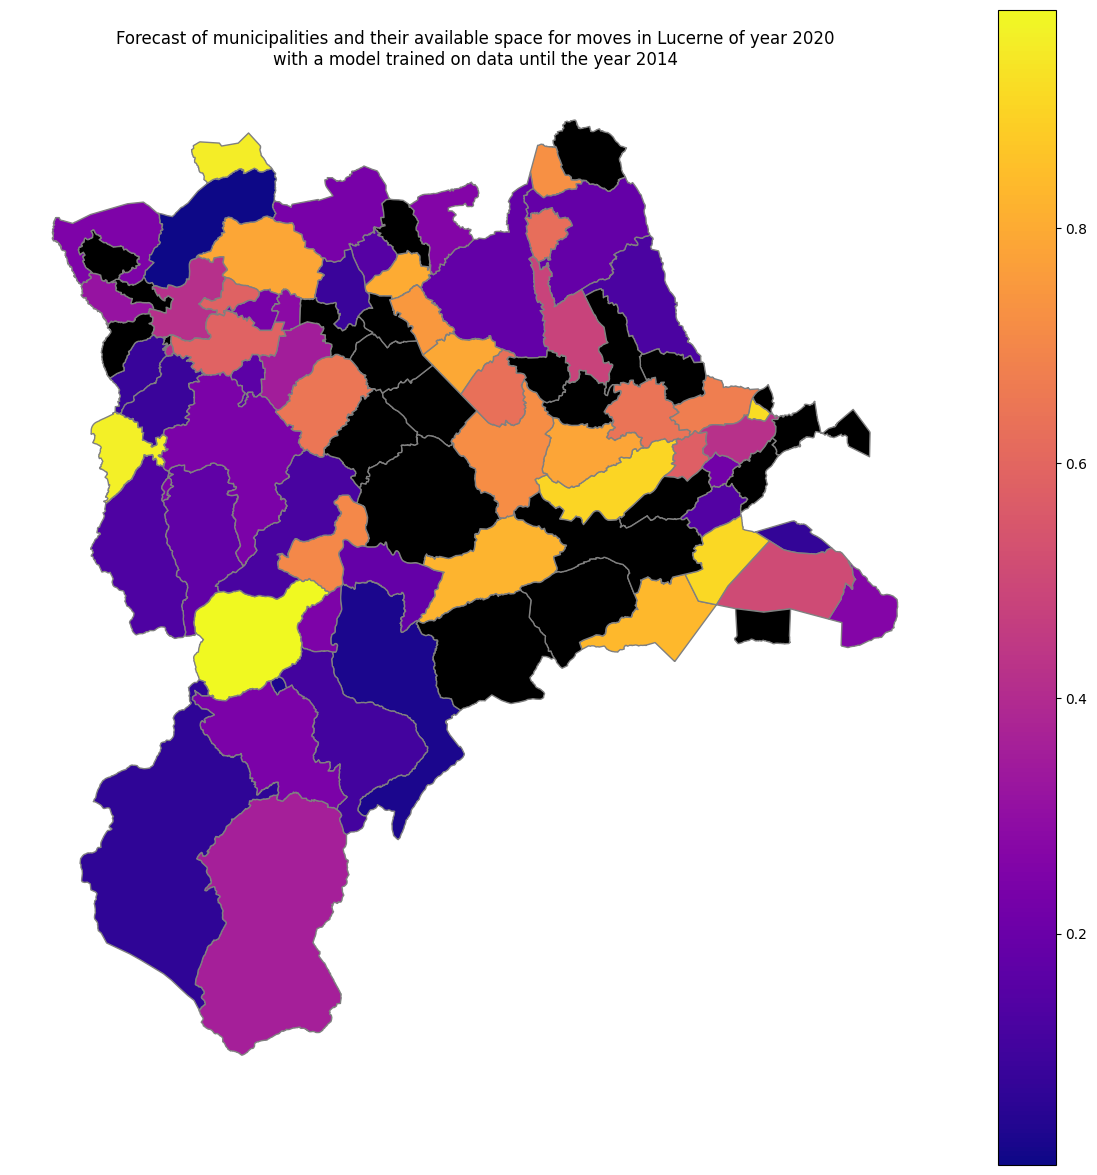

In [50]:
# plot the data on the map of lucerne
plot_on_lucerne_map(lu_municipalities_shapedata, "Forecast of municipalities and their available space for moves in Lucerne of year 2020\nwith a model trained on data until the year 2014", max_percentage=1)

Mit `max_percentage` auf 1 erkennt man, dass laut dem Modell 24 Gemeinden mehr Platz benötigen als es eigentlich gibt. Mit `max_percentage` auf 3, sind es noch 7. Für diesen Task brächte unser Modell also noch mehr Training und Fintuning für den produktiven Einsatz.

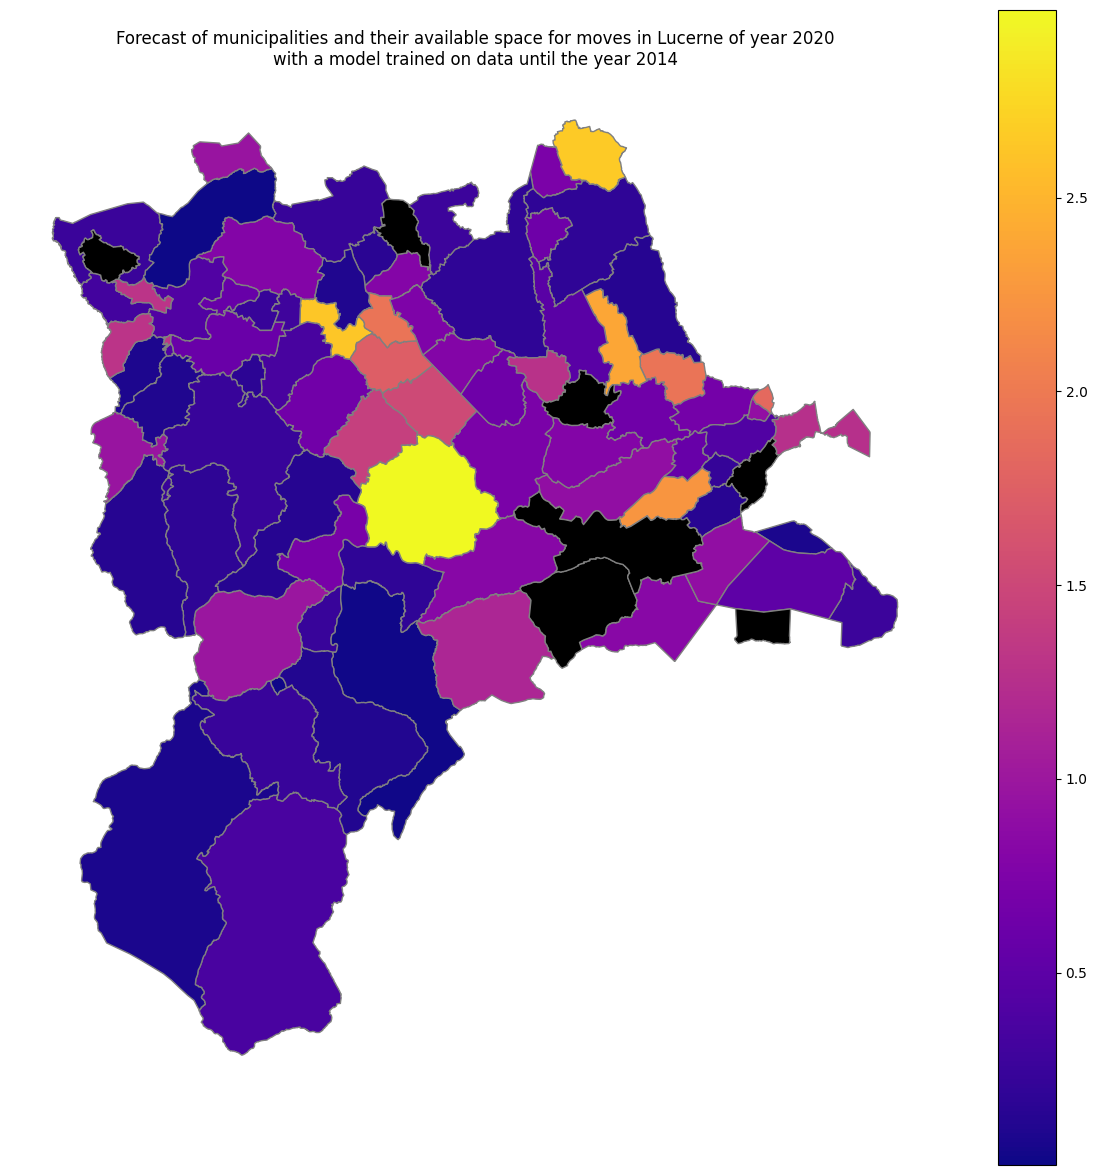

In [51]:
# plot the data on the map of lucerne
plot_on_lucerne_map(lu_municipalities_shapedata, "Forecast of municipalities and their available space for moves in Lucerne of year 2020\nwith a model trained on data until the year 2014", max_percentage=3)